In [3]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Read the CSV file
df = pd.read_csv('transactions.csv')

# Assuming 'transactions' is the column containing transaction data
transactions = df['transactions']

# Calculate mean and standard deviation
mean = np.mean(transactions)
std_dev = np.std(transactions)

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Convert datetime values to numerical representations (timestamps)
df['timestamp'] = df['date'].apply(lambda x: x.timestamp())

# Fit the KNN model using 'timestamp' and 'store_nbr' as features
X = df[['timestamp', 'store_nbr']].values
k = 5  # You can adjust the number of neighbors as needed
knn_model = NearestNeighbors(n_neighbors=k)
knn_model.fit(X)

# Take user inputs
new_date = pd.to_datetime(input("Enter the date (YYYY-MM-DD): "))
new_store_nbr = int(input("Enter the store number: "))
new_transaction_input = float(input("Enter the transaction amount: "))

# Convert user input date to timestamp
new_timestamp = new_date.timestamp()

# Find the k nearest neighbors to the new data point
new_data = np.array([[new_timestamp, new_store_nbr]])
distances, indices = knn_model.kneighbors(new_data)

# Generate an alternative new transaction value using the mean of the nearest neighbors' transactions
new_transaction_alternative = np.mean(transactions.iloc[indices[0]])

# Calculate the range based on mean ± standard deviation of the alternative transaction value
min_range = new_transaction_alternative - std_dev
max_range = new_transaction_alternative + std_dev

# Check if the user input transaction value falls within the range
if min_range <= new_transaction_input <= max_range:
    # Append a new row to the DataFrame
    new_row = {'date': new_date, 'store_nbr': new_store_nbr, 'transactions': new_transaction_input}
    df = df.append(new_row, ignore_index=True)
    print("User input transaction appended successfully.")
else:
    print(f"Your input transaction amount ({new_transaction_input}) is outside the range "
          f"of normal amount range ({min_range} to {max_range}).")

# Optionally, you can save the updated DataFrame to a new CSV file
# df.to_csv('updated_transactions.csv', index=False)

print("Updated DataFrame:")
print(df)


AttributeError: 'DataFrame' object has no attribute 'append'

/var/folders/ww/qjh9zpks52d4vsjxc4bg379h0000gn/T/ipykernel_5875/384933500.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_half['date'] = pd.to_datetime(first_half['date'])
/var/folders/ww/qjh9zpks52d4vsjxc4bg379h0000gn/T/ipykernel_5875/384933500.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_half['timestamp'] = first_half['date'].apply(lambda x: x.timestamp())


Evaluation Metrics:
Accuracy: 0.9894356075124568
Balanced Accuracy: 0.9495070334793763
F1 Score: 0.9447437664453076
Specificity: 0.9994674193806088


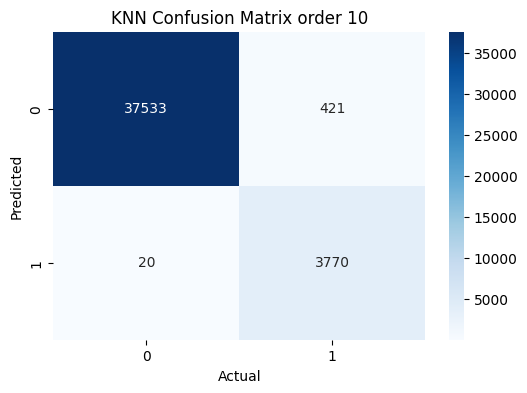

In [6]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('transactions.csv')

# Function to introduce error in a subset of data
def introduce_error(df, error_order, data_percentage):
    # Randomly select a percentage of the data
    sample_size = int(len(df) * data_percentage / 100)
    sample_indices = np.random.choice(df.index, size=sample_size, replace=False)
    
    # Introduce error by multiplying the transaction values
    df.loc[sample_indices, 'transactions'] *= error_order
    
    # Add a column to indicate error status
    df['error'] = 0
    df.loc[sample_indices, 'error'] = 1
    
    return df

# Introduce error in the DataFrame
df = introduce_error(df, error_order=10, data_percentage=10)

# Divide the DataFrame into two parts
total_rows = len(df)
split_index = total_rows // 2
first_half = df.iloc[:split_index]
second_half = df.iloc[split_index:]

# Calculate mean and standard deviation for the first half
first_half_mean = np.mean(first_half['transactions'])
first_half_std_dev = np.std(first_half['transactions'])

# Assuming 'transactions' is the column containing transaction data
transactions = first_half['transactions']

# Convert 'date' column to datetime format
first_half['date'] = pd.to_datetime(first_half['date'])

# Convert datetime values to numerical representations (timestamps)
first_half['timestamp'] = first_half['date'].apply(lambda x: x.timestamp())

# Fit the KNN model using 'timestamp' and 'store_nbr' as features
X = first_half[['timestamp', 'store_nbr']].values
k = 5  # You can adjust the number of neighbors as needed
knn_model = NearestNeighbors(n_neighbors=k)
knn_model.fit(X)
changed_count = 0
unchanged_count = 0
predicted_in_range = []
actual_error = []

# Function to process a single row as input
def process_input(row):
    global first_half, changed_count, unchanged_count, first_half_std_dev  # Specify global variables
    # Extract data from the row
    new_date = pd.to_datetime(row['date'])
    new_store_nbr = row['store_nbr']
    new_transaction_input = row['transactions']
    
    # Convert user input date to timestamp
    new_timestamp = new_date.timestamp()
    
    # Find the k nearest neighbors to the new data point
    new_data = np.array([[new_timestamp, new_store_nbr]])
    distances, indices = knn_model.kneighbors(new_data)
    
    # Generate an alternative new transaction value using the mean of the nearest neighbors' transactions
    new_transaction_alternative = np.mean(transactions.iloc[indices[0]])
    
    # Calculate the range based on mean ± standard deviation of the alternative transaction value
    min_range = new_transaction_alternative -  first_half_std_dev
    max_range = new_transaction_alternative + first_half_std_dev
    
    # Check if the user input transaction value falls within the range
    if min_range <= new_transaction_input <= max_range:
        changed_count += 1
        predicted_in_range.append(0)
    else:
        unchanged_count += 1
        predicted_in_range.append(1)
    actual_error.append(row['error'])

# Apply processing on the second half
for index, row in second_half.iterrows():
    process_input(row)

# Calculate evaluation metrics
accuracy = accuracy_score(actual_error, predicted_in_range)
balanced_accuracy = balanced_accuracy_score(actual_error, predicted_in_range)
f1 = f1_score(actual_error, predicted_in_range)

# Calculate specificity
tn, fp, _, _ = confusion_matrix(actual_error, predicted_in_range).ravel()
specificity = tn / (tn + fp)

print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)
print("Specificity:", specificity)
# Plot confusion matrix with predicted values on the y-axis
# Calculate confusion matrix
cm = confusion_matrix(actual_error, predicted_in_range)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm.T, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('KNN Confusion Matrix order 10')
plt.show()


/var/folders/ww/qjh9zpks52d4vsjxc4bg379h0000gn/T/ipykernel_5875/3006364059.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_half['date'] = pd.to_datetime(first_half['date'])
/var/folders/ww/qjh9zpks52d4vsjxc4bg379h0000gn/T/ipykernel_5875/3006364059.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_half['timestamp'] = first_half['date'].apply(lambda x: x.timestamp())


Evaluation Metrics:
Accuracy: 0.9969097355308547
Balanced Accuracy: 0.9846025304368584
Precision: 1.0
Recall: 0.9692050608737168
F1 Score: 0.9843617408170687
Specificity: 1.0


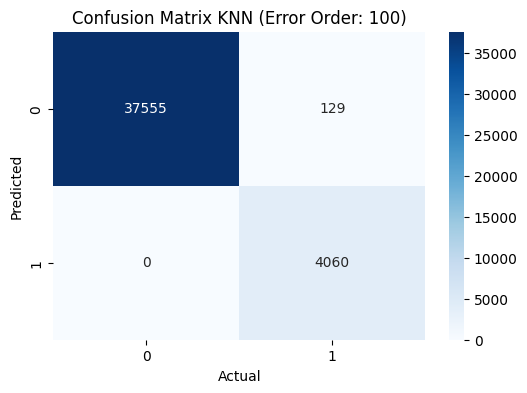

In [12]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('transactions.csv')

# Function to introduce error in a subset of data
def introduce_error(df, error_order, data_percentage):
    # Randomly select a percentage of the data
    sample_size = int(len(df) * data_percentage / 100)
    sample_indices = np.random.choice(df.index, size=sample_size, replace=False)
    
    # Introduce error by multiplying the transaction values
    df.loc[sample_indices, 'transactions'] *= error_order
    
    # Add a column to indicate error status
    df['error'] = 0
    df.loc[sample_indices, 'error'] = 1
    
    return df
error_order=100
# Introduce error in the DataFrame
df = introduce_error(df, error_order, data_percentage=10)

# Divide the DataFrame into two parts
total_rows = len(df)
split_index = total_rows // 2
first_half = df.iloc[:split_index]
second_half = df.iloc[split_index:]

# Calculate mean and standard deviation for the first half
first_half_mean = np.mean(first_half['transactions'])
first_half_std_dev = np.std(first_half['transactions'])

# Assuming 'transactions' is the column containing transaction data
transactions = first_half['transactions']

# Convert 'date' column to datetime format
first_half['date'] = pd.to_datetime(first_half['date'])

# Convert datetime values to numerical representations (timestamps)
first_half['timestamp'] = first_half['date'].apply(lambda x: x.timestamp())

# Fit the KNN model using 'timestamp' and 'store_nbr' as features
X = first_half[['timestamp', 'store_nbr']].values
k = 5  # You can adjust the number of neighbors as needed
knn_model = NearestNeighbors(n_neighbors=k)
knn_model.fit(X)
changed_count = 0
unchanged_count = 0
predicted_in_range = []
actual_error = []

# Function to process a single row as input
def process_input(row):
    global first_half, changed_count, unchanged_count, first_half_std_dev  # Specify global variables
    # Extract data from the row
    new_date = pd.to_datetime(row['date'])
    new_store_nbr = row['store_nbr']
    new_transaction_input = row['transactions']
    
    # Convert user input date to timestamp
    new_timestamp = new_date.timestamp()
    
    # Find the k nearest neighbors to the new data point
    new_data = np.array([[new_timestamp, new_store_nbr]])
    distances, indices = knn_model.kneighbors(new_data)
    
    # Generate an alternative new transaction value using the mean of the nearest neighbors' transactions
    new_transaction_alternative = np.mean(transactions.iloc[indices[0]])
    
    # Calculate the range based on mean ± standard deviation of the alternative transaction value
    min_range = new_transaction_alternative -  first_half_std_dev
    max_range = new_transaction_alternative + first_half_std_dev
    
    # Check if the user input transaction value falls within the range
    if min_range <= new_transaction_input <= max_range:
        changed_count += 1
        predicted_in_range.append(0)
    else:
        unchanged_count += 1
        predicted_in_range.append(1)
    actual_error.append(row['error'])

# Apply processing on the second half
for index, row in second_half.iterrows():
    process_input(row)

# Calculate evaluation metrics
accuracy = accuracy_score(actual_error, predicted_in_range)
balanced_accuracy = balanced_accuracy_score(actual_error, predicted_in_range)
precision = precision_score(actual_error, predicted_in_range)
recall = recall_score(actual_error, predicted_in_range)
f1 = f1_score(actual_error, predicted_in_range)

# Calculate specificity
tn, fp, _, _ = confusion_matrix(actual_error, predicted_in_range).ravel()
specificity = tn / (tn + fp)

print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Specificity:", specificity)

# Plot confusion matrix with predicted values on the y-axis
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(actual_error, predicted_in_range).T, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Confusion Matrix KNN (Error Order: {error_order})')
plt.show()


Evaluation Metrics:
Accuracy: 0.9484237255653507
Balanced Accuracy: 0.9713346114927837
Precision: 0.6605707078669399
Recall: 1.0
F1 Score: 0.7955947973037122
Specificity: 0.9426692229855674


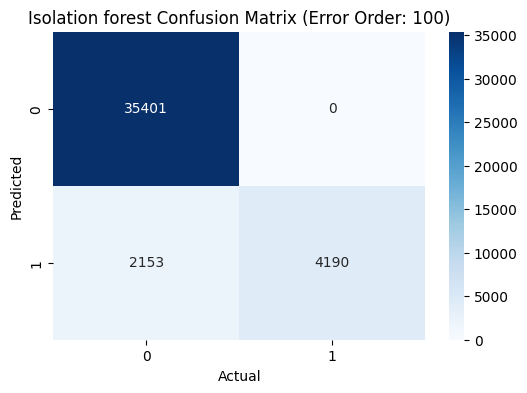

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('transactions.csv')

# Function to introduce error in a subset of data
def introduce_error(df, error_order, data_percentage):
    # Randomly select a percentage of the data
    sample_size = int(len(df) * data_percentage / 100)
    sample_indices = np.random.choice(df.index, size=sample_size, replace=False)
    
    # Introduce error by multiplying the transaction values
    df.loc[sample_indices, 'transactions'] *= error_order
    
    # Add a column to indicate error status
    df['error'] = 0
    df.loc[sample_indices, 'error'] = 1
    
    return df

error_order = 100
# Introduce error in the DataFrame
df = introduce_error(df, error_order, data_percentage=10)

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Convert datetime values to numerical representations (timestamps)
df['timestamp'] = df['date'].apply(lambda x: x.timestamp())

# Divide the DataFrame into two parts
total_rows = len(df)
split_index = total_rows // 2
first_half = df.iloc[:split_index]
second_half = df.iloc[split_index:]

# Fit the Isolation Forest model using all available features
features = ['timestamp', 'store_nbr', 'transactions']  # Features used for training
X_train = first_half[features]
isolation_forest_model = IsolationForest(contamination=0.1)  # Adjust contamination as needed
isolation_forest_model.fit(X_train)

# Predict anomalies for the second half
predicted_labels = isolation_forest_model.predict(second_half[features])

# Convert predicted labels to binary (0 for inliers, 1 for outliers)
predicted_in_range = np.where(predicted_labels == 1, 0, 1)

# Calculate evaluation metrics
actual_error = second_half['error']
accuracy = accuracy_score(actual_error, predicted_in_range)
balanced_accuracy = balanced_accuracy_score(actual_error, predicted_in_range)
precision = precision_score(actual_error, predicted_in_range)
recall = recall_score(actual_error, predicted_in_range)
f1 = f1_score(actual_error, predicted_in_range)

# Calculate specificity
tn, fp, _, _ = confusion_matrix(actual_error, predicted_in_range).ravel()
specificity = tn / (tn + fp)

print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Specificity:", specificity)

# Plot confusion matrix with predicted values on the y-axis
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(actual_error, predicted_in_range).T, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Isolation forest Confusion Matrix (Error Order: {error_order})')
plt.show()


Evaluation Metrics:
Accuracy: 0.8291730548102721
Balanced Accuracy: 0.9050491331788768
Precision: 0.3702755210173084
Recall: 1.0
F1 Score: 0.540439517948057
Specificity: 0.8100982663577535


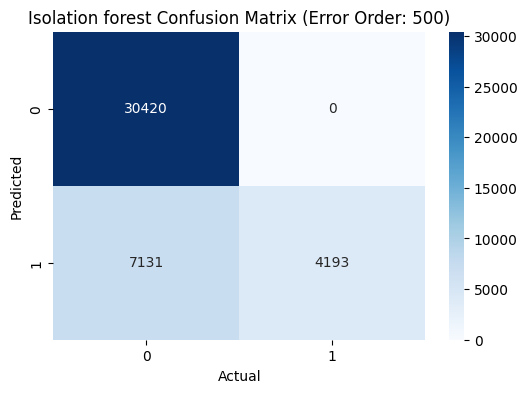

In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('transactions.csv')

# Function to introduce error in a subset of data
def introduce_error(df, error_order, data_percentage):
    # Randomly select a percentage of the data
    sample_size = int(len(df) * data_percentage / 100)
    sample_indices = np.random.choice(df.index, size=sample_size, replace=False)
    
    # Introduce error by multiplying the transaction values
    df.loc[sample_indices, 'transactions'] *= error_order
    
    # Add a column to indicate error status
    df['error'] = 0
    df.loc[sample_indices, 'error'] = 1
    
    return df

error_order = 500
# Introduce error in the DataFrame
df = introduce_error(df, error_order, data_percentage=10)

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Convert datetime values to numerical representations (timestamps)
df['timestamp'] = df['date'].apply(lambda x: x.timestamp())

# Divide the DataFrame into two parts
total_rows = len(df)
split_index = total_rows // 2
first_half = df.iloc[:split_index]
second_half = df.iloc[split_index:]

# Fit the Isolation Forest model using all available features
features = ['timestamp', 'store_nbr', 'transactions']  # Features used for training
X_train = first_half[features]
isolation_forest_model = IsolationForest(contamination=0.1, n_estimators=30, max_samples='auto', max_features=1.0, bootstrap=True)  
# Adjust other parameters as needed
isolation_forest_model.fit(X_train)

# Predict anomalies for the second half
predicted_labels = isolation_forest_model.predict(second_half[features])

# Convert predicted labels to binary (0 for inliers, 1 for outliers)
predicted_in_range = np.where(predicted_labels == 1, 0, 1)

# Calculate evaluation metrics
actual_error = second_half['error']
accuracy = accuracy_score(actual_error, predicted_in_range)
balanced_accuracy = balanced_accuracy_score(actual_error, predicted_in_range)
precision = precision_score(actual_error, predicted_in_range)
recall = recall_score(actual_error, predicted_in_range)
f1 = f1_score(actual_error, predicted_in_range)

# Calculate specificity
tn, fp, _, _ = confusion_matrix(actual_error, predicted_in_range).ravel()
specificity = tn / (tn + fp)

print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Specificity:", specificity)

# Plot confusion matrix with predicted values on the y-axis
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(actual_error, predicted_in_range).T, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Isolation forest Confusion Matrix (Error Order: {error_order})')
plt.show()


Evaluation Metrics:
Accuracy: 0.10051743963204293
Balanced Accuracy: 0.5
Precision: 0.10051743963204293
Recall: 1.0
F1 Score: 0.1826730518067044
Specificity: 0.0


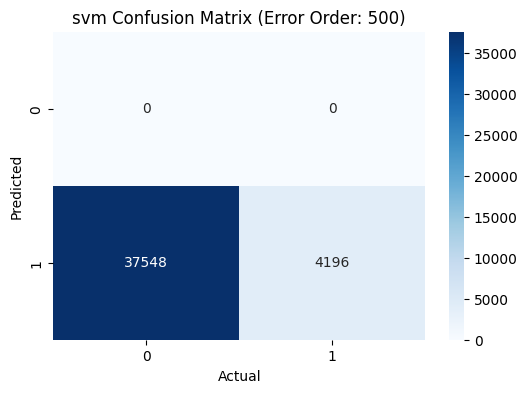

In [14]:
import pandas as pd
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('transactions.csv')

# Function to introduce error in a subset of data
def introduce_error(df, error_order, data_percentage):
    # Randomly select a percentage of the data
    sample_size = int(len(df) * data_percentage / 100)
    sample_indices = np.random.choice(df.index, size=sample_size, replace=False)
    
    # Introduce error by multiplying the transaction values
    df.loc[sample_indices, 'transactions'] *= error_order
    
    # Add a column to indicate error status
    df['error'] = 0
    df.loc[sample_indices, 'error'] = 1
    
    return df

error_order = 500
# Introduce error in the DataFrame
df = introduce_error(df, error_order, data_percentage=10)

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Convert datetime values to numerical representations (timestamps)
df['timestamp'] = df['date'].apply(lambda x: x.timestamp())

# Divide the DataFrame into two parts
total_rows = len(df)
split_index = total_rows // 2
first_half = df.iloc[:split_index]
second_half = df.iloc[split_index:]

# Fit the One-Class SVM model using all available features
features = ['timestamp', 'store_nbr']  # Features used for training
X_train = first_half[features]
one_class_svm_model = OneClassSVM(nu=0.1, kernel='rbf', gamma='scale')  
# Adjust nu parameter as needed, it controls the proportion of outliers
one_class_svm_model.fit(X_train)

# Predict anomalies for the second half
predicted_labels = one_class_svm_model.predict(second_half[features])

# Convert predicted labels to binary (0 for inliers, 1 for outliers)
predicted_in_range = np.where(predicted_labels == 1, 0, 1)

# Calculate evaluation metrics
actual_error = second_half['error']
accuracy = accuracy_score(actual_error, predicted_in_range)
balanced_accuracy = balanced_accuracy_score(actual_error, predicted_in_range)
precision = precision_score(actual_error, predicted_in_range)
recall = recall_score(actual_error, predicted_in_range)
f1 = f1_score(actual_error, predicted_in_range)

# Calculate specificity
tn, fp, _, _ = confusion_matrix(actual_error, predicted_in_range).ravel()
specificity = tn / (tn + fp)

print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Specificity:", specificity)

# Plot confusion matrix with predicted values on the y-axis
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(actual_error, predicted_in_range).T, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'svm Confusion Matrix (Error Order: {error_order})')
plt.show()

Evaluation Metrics:
Accuracy: 0.9503401686469912
Balanced Accuracy: 0.8629179006036464
Precision: 0.7475449101796408
Recall: 0.753864734299517
F1 Score: 0.7506915213469633
Specificity: 0.9719710669077758


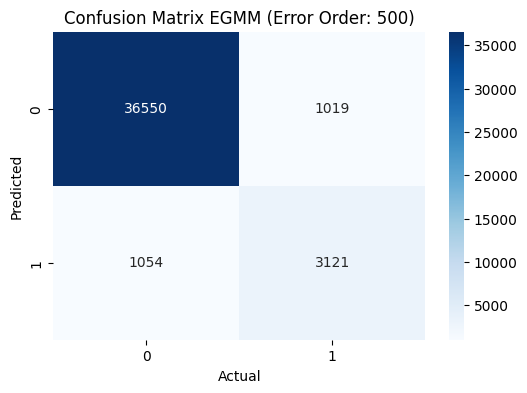

In [ ]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('transactions.csv')

# Function to introduce error in a subset of data
def introduce_error(df, error_order, data_percentage):
    # Randomly select a percentage of the data
    sample_size = int(len(df) * data_percentage / 100)
    sample_indices = np.random.choice(df.index, size=sample_size, replace=False)
    
    # Introduce error by multiplying the transaction values
    df.loc[sample_indices, 'transactions'] *= error_order
    
    # Add a column to indicate error status
    df['error'] = 0
    df.loc[sample_indices, 'error'] = 1
    
    return df

error_order = 500
# Introduce error in the DataFrame
df = introduce_error(df, error_order, data_percentage=10)

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Convert datetime values to numerical representations (timestamps)
df['timestamp'] = df['date'].apply(lambda x: x.timestamp())

# Divide the DataFrame into two parts
total_rows = len(df)
split_index = total_rows // 2
first_half = df.iloc[:split_index]
second_half = df.iloc[split_index:]

# Fit the Gaussian Mixture Model (EGMM) using all available features
features = ['timestamp', 'store_nbr', 'transactions']  # Features used for training
X_train = first_half[features]
egmm_model = GaussianMixture(n_components=3, covariance_type='full', random_state=42)  # Example: 3 components
egmm_model.fit(X_train)

# Calculate the probability densities for each sample
densities = egmm_model.score_samples(second_half[features])

# Set a threshold for anomaly detection (e.g., below a certain percentile)
threshold = np.percentile(densities, 10)  # Example: 10th percentile

# Predict anomalies for the second half
predicted_in_range = (densities < threshold).astype(int)

# Calculate evaluation metrics
actual_error = second_half['error']
accuracy = accuracy_score(actual_error, predicted_in_range)
balanced_accuracy = balanced_accuracy_score(actual_error, predicted_in_range)
precision = precision_score(actual_error, predicted_in_range)
recall = recall_score(actual_error, predicted_in_range)
f1 = f1_score(actual_error, predicted_in_range)

# Calculate specificity
tn, fp, _, _ = confusion_matrix(actual_error, predicted_in_range).ravel()
specificity = tn / (tn + fp)

print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Specificity:", specificity)

# Plot confusion matrix with predicted values on the y-axis
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(actual_error, predicted_in_range).T, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Confusion Matrix EGMM (Error Order: {error_order})')
plt.show()


Evaluation Metrics:
Accuracy: 0.8242382138750479
Balanced Accuracy: 0.5111741882322176
Precision: 0.11976047904191617
Recall: 0.12013455069678039
F1 Score: 0.11994722322178242
Specificity: 0.9022138257676547


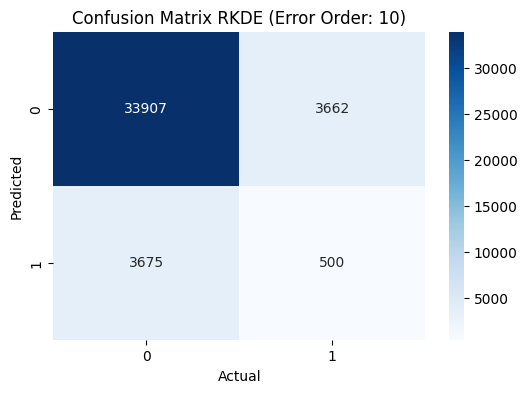

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kernel_density import KDEMultivariate

# Read the CSV file
df = pd.read_csv('transactions.csv')

# Function to introduce error in a subset of data
def introduce_error(df, error_order, data_percentage):
    # Randomly select a percentage of the data
    sample_size = int(len(df) * data_percentage / 100)
    sample_indices = np.random.choice(df.index, size=sample_size, replace=False)
    
    # Introduce error by multiplying the transaction values
    df.loc[sample_indices, 'transactions'] *= error_order
    
    # Add a column to indicate error status
    df['error'] = 0
    df.loc[sample_indices, 'error'] = 1
    
    return df

error_order = 10
# Introduce error in the DataFrame
df = introduce_error(df, error_order, data_percentage=10)

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Convert datetime values to numerical representations (timestamps)
df['timestamp'] = df['date'].apply(lambda x: x.timestamp())

# Divide the DataFrame into two parts
total_rows = len(df)
split_index = total_rows // 2
first_half = df.iloc[:split_index]
second_half = df.iloc[split_index:]

# Fit the RKDE model using all available features
features = ['timestamp', 'store_nbr', 'transactions']  # Features used for training
X_train = first_half[features].values
rkde_model = KDEMultivariate(data=X_train, var_type='ccc', bw='normal_reference')

# Calculate the probability densities for the second half
densities = rkde_model.pdf(second_half[features].values)

# Set a threshold for anomaly detection (e.g., below a certain percentile)
threshold = np.percentile(densities, 10)  # Example: 10th percentile

# Predict anomalies for the second half
predicted_in_range = (densities < threshold).astype(int)

# Calculate evaluation metrics
actual_error = second_half['error']
accuracy = accuracy_score(actual_error, predicted_in_range)
balanced_accuracy = balanced_accuracy_score(actual_error, predicted_in_range)
precision = precision_score(actual_error, predicted_in_range)
recall = recall_score(actual_error, predicted_in_range)
f1 = f1_score(actual_error, predicted_in_range)

# Calculate specificity
tn, fp, _, _ = confusion_matrix(actual_error, predicted_in_range).ravel()
specificity = tn / (tn + fp)

print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Specificity:", specificity)

# Plot confusion matrix with predicted values on the y-axis
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(actual_error, predicted_in_range).T, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Confusion Matrix RKDE (Error Order: {error_order})')
plt.show()

/var/folders/ww/qjh9zpks52d4vsjxc4bg379h0000gn/T/ipykernel_49853/3246791560.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_half['date'] = pd.to_datetime(first_half['date'])
/var/folders/ww/qjh9zpks52d4vsjxc4bg379h0000gn/T/ipykernel_49853/3246791560.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_half['timestamp'] = first_half['date'].apply(lambda x: x.timestamp())


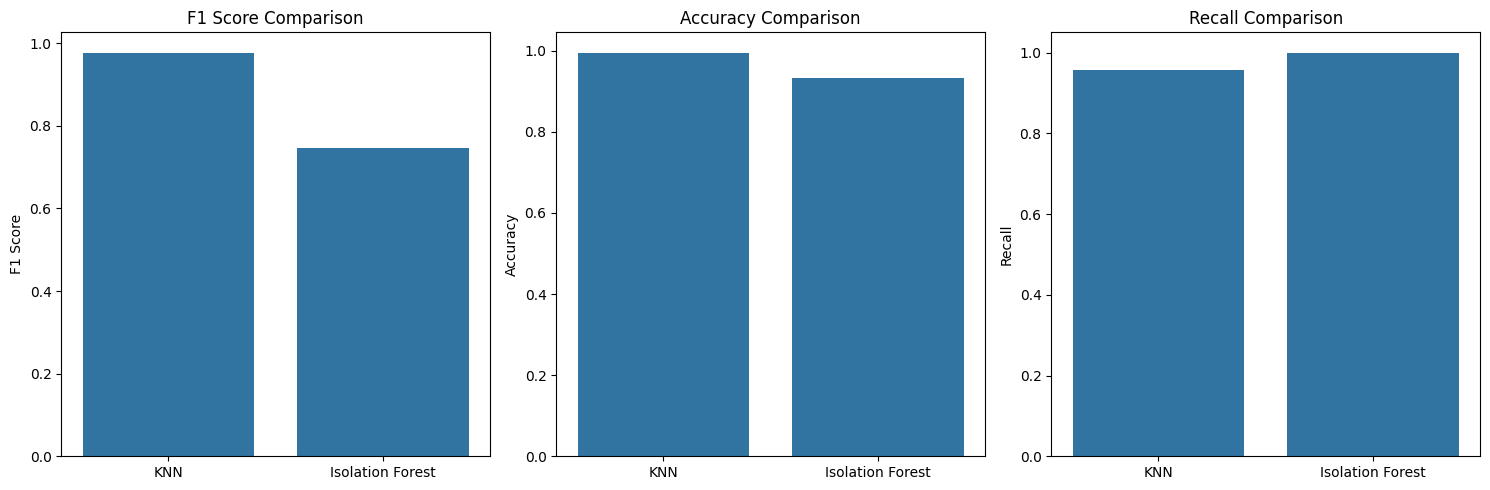

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('transactions.csv')

# Function to introduce error in a subset of data
def introduce_error(df, error_order, data_percentage):
    # Randomly select a percentage of the data
    sample_size = int(len(df) * data_percentage / 100)
    sample_indices = np.random.choice(df.index, size=sample_size, replace=False)
    
    # Introduce error by multiplying the transaction values
    df.loc[sample_indices, 'transactions'] *= error_order
    
    # Add a column to indicate error status
    df['error'] = 0
    df.loc[sample_indices, 'error'] = 1
    
    return df

# Function to evaluate KNN model
def evaluate_knn(df, error_order):
    # Divide the DataFrame into two parts
    total_rows = len(df)
    split_index = total_rows // 2
    first_half = df.iloc[:split_index]
    second_half = df.iloc[split_index:]

    # Assuming 'transactions' is the column containing transaction data
    transactions = first_half['transactions']

    # Convert 'date' column to datetime format
    first_half['date'] = pd.to_datetime(first_half['date'])

    # Convert datetime values to numerical representations (timestamps)
    first_half['timestamp'] = first_half['date'].apply(lambda x: x.timestamp())

    # Fit the KNN model using 'timestamp' and 'store_nbr' as features
    X = first_half[['timestamp', 'store_nbr']].values
    k = 5  # You can adjust the number of neighbors as needed
    knn_model = NearestNeighbors(n_neighbors=k)
    knn_model.fit(X)

    predicted_in_range = []
    actual_error = []

    # Function to process a single row as input
    def process_input(row):
        nonlocal first_half
        # Extract data from the row
        new_date = pd.to_datetime(row['date'])
        new_store_nbr = row['store_nbr']
        new_transaction_input = row['transactions']

        # Convert user input date to timestamp
        new_timestamp = new_date.timestamp()

        # Find the k nearest neighbors to the new data point
        new_data = np.array([[new_timestamp, new_store_nbr]])
        distances, indices = knn_model.kneighbors(new_data)

        # Generate an alternative new transaction value using the mean of the nearest neighbors' transactions
        new_transaction_alternative = np.mean(transactions.iloc[indices[0]])

        # Calculate the range based on mean ± standard deviation of the alternative transaction value
        first_half_std_dev = np.std(transactions)
        min_range = new_transaction_alternative - first_half_std_dev
        max_range = new_transaction_alternative + first_half_std_dev

        # Check if the user input transaction value falls within the range
        if min_range <= new_transaction_input <= max_range:
            predicted_in_range.append(0)
        else:
            predicted_in_range.append(1)
        actual_error.append(row['error'])

    # Apply processing on the second half
    for _, row in second_half.iterrows():
        process_input(row)

    # Calculate evaluation metrics
    accuracy = accuracy_score(actual_error, predicted_in_range)
    recall = recall_score(actual_error, predicted_in_range)
    f1 = f1_score(actual_error, predicted_in_range)

    return accuracy, recall, f1

# Function to evaluate Isolation Forest model
def evaluate_isolation_forest(df, error_order):
    # Convert 'date' column to datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Convert datetime values to numerical representations (timestamps)
    df['timestamp'] = df['date'].apply(lambda x: x.timestamp())

    # Divide the DataFrame into two parts
    total_rows = len(df)
    split_index = total_rows // 2
    first_half = df.iloc[:split_index]
    second_half = df.iloc[split_index:]

    # Fit the Isolation Forest model using all available features
    features = ['timestamp', 'store_nbr', 'transactions']  # Features used for training
    X_train = first_half[features]
    isolation_forest_model = IsolationForest(contamination=0.1, n_estimators=30, max_samples='auto', max_features=1.0, bootstrap=True)  
    # Adjust other parameters as needed
    isolation_forest_model.fit(X_train)

    # Predict anomalies for the second half
    predicted_labels = isolation_forest_model.predict(second_half[features])

    # Convert predicted labels to binary (0 for inliers, 1 for outliers)
    predicted_in_range = np.where(predicted_labels == 1, 0, 1)

    # Calculate evaluation metrics
    actual_error = second_half['error']
    accuracy = accuracy_score(actual_error, predicted_in_range)
    recall = recall_score(actual_error, predicted_in_range)
    f1 = f1_score(actual_error, predicted_in_range)

    return accuracy, recall, f1

# Introduce error only once
df_with_error = introduce_error(df.copy(), error_order=100, data_percentage=10)

# Evaluate both algorithms on the same data
accuracy_knn, recall_knn, f1_knn = evaluate_knn(df_with_error, error_order=100)
accuracy_isolation, recall_isolation, f1_isolation = evaluate_isolation_forest(df_with_error, error_order=100)

# Plot F1 Score, Accuracy, and Recall for both algorithms
plt.figure(figsize=(15, 5))

# F1 Score
plt.subplot(1, 3, 1)
sns.barplot(x=['KNN', 'Isolation Forest'], y=[f1_knn, f1_isolation])
plt.title('F1 Score Comparison')
plt.ylabel('F1 Score')

# Accuracy
plt.subplot(1, 3, 2)
sns.barplot(x=['KNN', 'Isolation Forest'], y=[accuracy_knn, accuracy_isolation])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')

# Recall
plt.subplot(1, 3, 3)
sns.barplot(x=['KNN', 'Isolation Forest'], y=[recall_knn, recall_isolation])
plt.title('Recall Comparison')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()
